In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths

from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group

In [6]:
np.random.seed(seed = 0)

In [7]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
n = [1*10**4, 2*10**4, 5*10**4, 2*10**5, 5*10**5, 1*10**6, 2*10**6]
z = [0.2, 0.5, 1,1.1, 1.2, 1.5,1.8, 2,2.2, 2.5,2.7,3, 3.5, 3.8, 4]
#z = [0.2, 0.5, 1, 2.5, 3]

zstr = [str(el*100)+'%' for el in z]
ERRORS = np.zeros([len(n), len(z)])
ERRORS_pd = pd.DataFrame(ERRORS, index = n, columns = zstr)

for i,N in enumerate(n):
    np.random.seed(seed = 0)
    D =  2
    x = int((N)**(1/4))
    kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
    centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
    r_small = [0.122]*5
    r_big = [0.2,0.2,0.2, 0.2,0.2]
    kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
    kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

    std = 2
    stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                      [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
    kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

    data3 = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
    data3 = calculate_ite(data3.copy(), treatment = 'Treatment',
                         counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

    clusts = [int((y*x)**2) for y in z]
    
    #CALCULATE ITES
    f1_kwargs = {'n_estimators':400, 'max_depth':18}
    f2_kwargs = {'n_estimators':400, 'max_depth':18}

    data3, models = predict_cf(data3.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                              f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                              f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')


    for j,clusters in enumerate(clusts):
        print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))

        data = data3.copy()
        #BOX CLUSTERING
        col_select = ['x0', 'x1']
        data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )

        #CALCULATE ATT PER CLUSTER
        ite_name = 'ITE-GDBR'
        box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
                   points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
                    hom_name = 'Box-Hom', att = False)

        #OPTIMAL CLUSTERING
        all_data = [box2]

        names_to_give = ['Box2-Cl2']
        names_to_find= ['Box-ATT']

        weights = ['Box-Weights']

        clusts = 7
        val = 6
        for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
            all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                              cluster_name = name, N=N, val = val )

        data2 = data.copy()

        #MERGE CLUSTERS WITH INITIAL DATA
        merge_names = ['Box-Cluster']
        class_names = ['Box2-Cl2']

        for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
            dd2 = dd[[merge_name, class_name]]


            data2 = data2.merge(dd2, on = merge_name, how = 'left' )

        #CALCULATE ERROR
        ite_column = 'ITE-GDBR'
        for clust2 in class_names:
            data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

        errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T
        error = errors.sort_values(by = 'mean').iloc[0,0]
        ERRORS_pd.loc[N,zstr[j]] = error

Number of Clusters:4, Number of Points:10000
Did not pick 6, it picked: 1
Number of Clusters:25, Number of Points:10000
Did not pick 6, it picked: 1
Number of Clusters:100, Number of Points:10000


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not pick 6, it picked: 2
Number of Clusters:121, Number of Points:10000
Did not pick 6, it picked: 3
Number of Clusters:144, Number of Points:10000
Did not pick 6, it picked: 3
Number of Clusters:225, Number of Points:10000
Did not pick 6, it picked: 5
Number of Clusters:324, Number of Points:10000
Number of Clusters:400, Number of Points:10000
Did not pick 6, it picked: 7
Number of Clusters:484, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:625, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:729, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:900, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:1225, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:1444, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:1600, Number of Points:10000
Did not pick 6, it picked: 0
Number of Clusters:4, Number of Points:20000
Did not pick 6, it picked: 1
Number of C

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of Clusters:121, Number of Points:20000
Did not pick 6, it picked: 3
Number of Clusters:146, Number of Points:20000
Did not pick 6, it picked: 3
Number of Clusters:174, Number of Points:20000
Did not pick 6, it picked: 4
Number of Clusters:272, Number of Points:20000
Did not pick 6, it picked: 5
Number of Clusters:392, Number of Points:20000
Number of Clusters:484, Number of Points:20000
Did not pick 6, it picked: 7
Number of Clusters:585, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:756, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:882, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:1089, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:1482, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:1747, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:1936, Number of Points:20000
Did not pick 6, it picked: 0
Number of Clusters:7, Number of Point

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not pick 6, it picked: 2
Number of Clusters:196, Number of Points:50000
Did not pick 6, it picked: 4
Number of Clusters:237, Number of Points:50000
Did not pick 6, it picked: 4
Number of Clusters:282, Number of Points:50000
Did not pick 6, it picked: 4
Number of Clusters:441, Number of Points:50000
Number of Clusters:635, Number of Points:50000
Did not pick 6, it picked: 7
Number of Clusters:784, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:948, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:1225, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:1428, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:1764, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:2401, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:2830, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:3136, Number of Points:50000
Did not pick 6, it picked: 0
Number

In [110]:
error

0.18607749696977458

In [10]:
ERRORS_pd

,20.0%,50.0%,100%,110.00000000000001%,120.0%,150.0%,180.0%,200%,220.00000000000003%,250.0%,270.0%,300%,350.0%,380.0%,400%
10000,1.471418,1.313426,1.124400,0.967917,1.019479,0.894418,0.841120,0.851179,0.851312,0.873736,0.913289,0.959230,1.004516,1.061195,1.067017
20000,1.450929,1.260966,0.915311,0.926726,0.837508,0.691084,0.747207,0.691061,0.747651,0.737472,0.703596,0.784825,0.754488,0.850226,0.900778
50000,1.462446,1.130176,0.690096,0.715657,0.605957,0.645630,0.624661,0.656669,0.632526,0.633367,0.631121,0.662973,0.654628,0.702164,0.690207
200000,1.397129,1.027049,0.462229,0.434112,0.415766,0.350337,0.463491,0.459219,0.471028,0.477720,0.467536,0.483864,0.500870,0.502399,0.521313
500000,1.278824,0.712566,0.443984,0.391704,0.331222,0.271913,0.244047,0.231134,0.234447,0.267872,0.367767,0.364587,0.391669,0.407979,0.424640
1000000,1.218767,0.636062,0.325093,0.310543,0.281122,0.236581,0.206953,0.182977,0.193073,0.178731,0.173528,0.215394,0.306133,0.342342,0.364062
2000000,1.132681,0.525909,0.278965,0.246320,0.243515,0.201171,0.187448,0.161310,0.150462,0.137422,0.134344,0.128707,0.133561,0.151536,0.186077


In [90]:
idx_min = ERRORS_pd.idxmin(axis = 1)
box_lengths = pd.DataFrame([[1/(y*int(t**(1/4))) for y in z] for t in n], index = n, columns = zstr)
box_lengths

,20.0%,50.0%,100%,110.00000000000001%,120.0%,150.0%,180.0%,200%,220.00000000000003%,250.0%,270.0%,300%,350.0%,380.0%,400%
10000,0.500000,0.200000,0.100000,0.090909,0.083333,0.066667,0.055556,0.050000,0.045455,0.040000,0.037037,0.033333,0.028571,0.026316,0.025000
20000,0.454545,0.181818,0.090909,0.082645,0.075758,0.060606,0.050505,0.045455,0.041322,0.036364,0.033670,0.030303,0.025974,0.023923,0.022727
50000,0.357143,0.142857,0.071429,0.064935,0.059524,0.047619,0.039683,0.035714,0.032468,0.028571,0.026455,0.023810,0.020408,0.018797,0.017857
200000,0.238095,0.095238,0.047619,0.043290,0.039683,0.031746,0.026455,0.023810,0.021645,0.019048,0.017637,0.015873,0.013605,0.012531,0.011905
500000,0.192308,0.076923,0.038462,0.034965,0.032051,0.025641,0.021368,0.019231,0.017483,0.015385,0.014245,0.012821,0.010989,0.010121,0.009615
1000000,0.161290,0.064516,0.032258,0.029326,0.026882,0.021505,0.017921,0.016129,0.014663,0.012903,0.011947,0.010753,0.009217,0.008489,0.008065
2000000,0.135135,0.054054,0.027027,0.024570,0.022523,0.018018,0.015015,0.013514,0.012285,0.010811,0.010010,0.009009,0.007722,0.007112,0.006757


In [34]:
min_length = np.zeros([len(idx_min), 2])
for i, (indx, val) in enumerate(idx_min.items()):
    print(indx, val)
    min_length[i,0] = int(indx)
    min_length[i,1] = box_lengths.loc[indx, val]
    

10000 180.0%
20000 200%
50000 120.0%
200000 150.0%
500000 200%
1000000 270.0%
2000000 300%


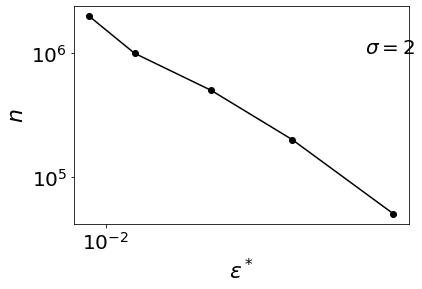

In [109]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(1,1)
line = ax.plot(min_length[2:,1], min_length[2:,0], 'k-o', label = r'$\sigma=2$')
#ax.set_yticks(min_length[2:,1])

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#plt.ticklabel_format(style='sci', axis='y',scilimits= (0,0))
ax.set_yticks([ 10000, 100000, 1000000])
ax.set_yscale('log')
ax.set_xscale('log')

#plt.ticklabel_format(useOffset=False)
plt.minorticks_off()
ax.annotate(r'$\sigma=2$',(0.05,10**6))
ax.set_xlabel(r'$\epsilon^*$')
ax.set_ylabel(r'$n$')

#plt.majorticks_off()

#ax.legend()
fig.show()

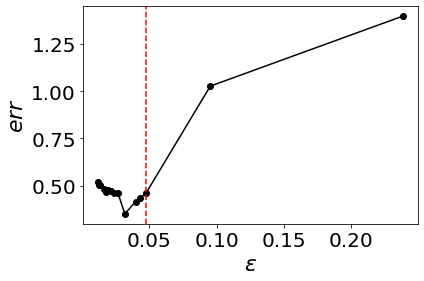

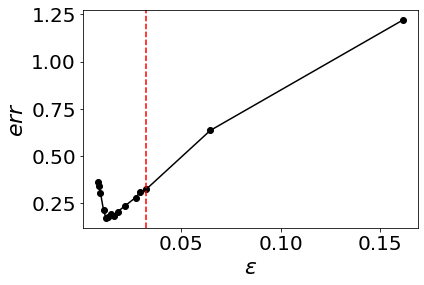

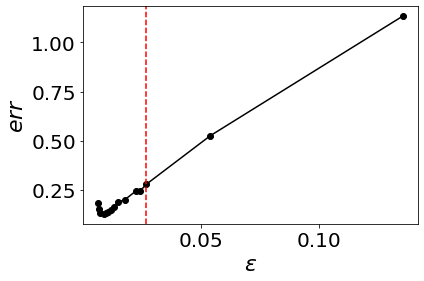

In [108]:
indexes = [200000, 1000000, 2000000]

for indx in indexes:
    fig, ax = plt.subplots(1,1)
    plt.plot( box_lengths.loc[indx],ERRORS_pd.loc[indx],'k-o')
   # ax.set_yscale('log')
    e_used = 1/int(indx**(1/4))
    ax.axvline(e_used, c = 'r', linestyle = '--')
    ax.set_xlabel(r'$\epsilon$')
    ax.set_ylabel(r'$err$')